In [304]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch.utils.data import DataLoader
from torch.nn import Linear, Conv2d

from torchvision.models import resnet18
from torchvision.transforms import v2

from src.classifier.utils.spike_to_img import AtisImageDataset

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns

plt.style.use("https://raw.githubusercontent.com/FabianSchubert/mpl_style/main/custom_style.mplstyle")
plt.rcParams["figure.dpi"] = 150

import pandas as pd

import numpy as np

import os

import random

In [280]:
class SynthDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = labels
        self.transform = transform

        assert self.data.shape[0] == len(self.labels)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [288]:
N_OUT = 2
N_SUBDIV = 2
WIDTH, HEIGHT = 304, 240
WIDTH_TILE, HEIGHT_TILE = WIDTH // N_SUBDIV, HEIGHT // N_SUBDIV

CLASSES = ["cars", "pedestrians"]

transform = v2.Compose([
    v2.RandomResizedCrop((HEIGHT_TILE, WIDTH_TILE), scale=(0.7, 1.0)),
    v2.RandomHorizontalFlip(),
])

BASE_FOLD = "/home/fabian/Work/carla_sim_gen_samples/"

#images = os.listdir(os.path.join(BASE_FOLD, "images/"))
labels_data = pd.read_csv(os.path.join(BASE_FOLD, "labels.csv"), header=None)

n_data = len(labels_data)

labels = labels_data[1].tolist()
img_files = [str(x).zfill(5) + ".png" for x in labels_data[0].tolist()]

data = np.zeros((n_data, 3, HEIGHT_TILE, WIDTH_TILE), dtype=np.uint8)
for i in range(n_data):
    img = plt.imread(os.path.join(BASE_FOLD, "images", img_files[i]))
    data[i] = img.transpose(2, 0, 1)

dataset = SynthDataset(data, labels, transform=transform)

In [309]:
split_ratio = 0.7
n_train = int(n_data * split_ratio)
n_val = n_data - n_train

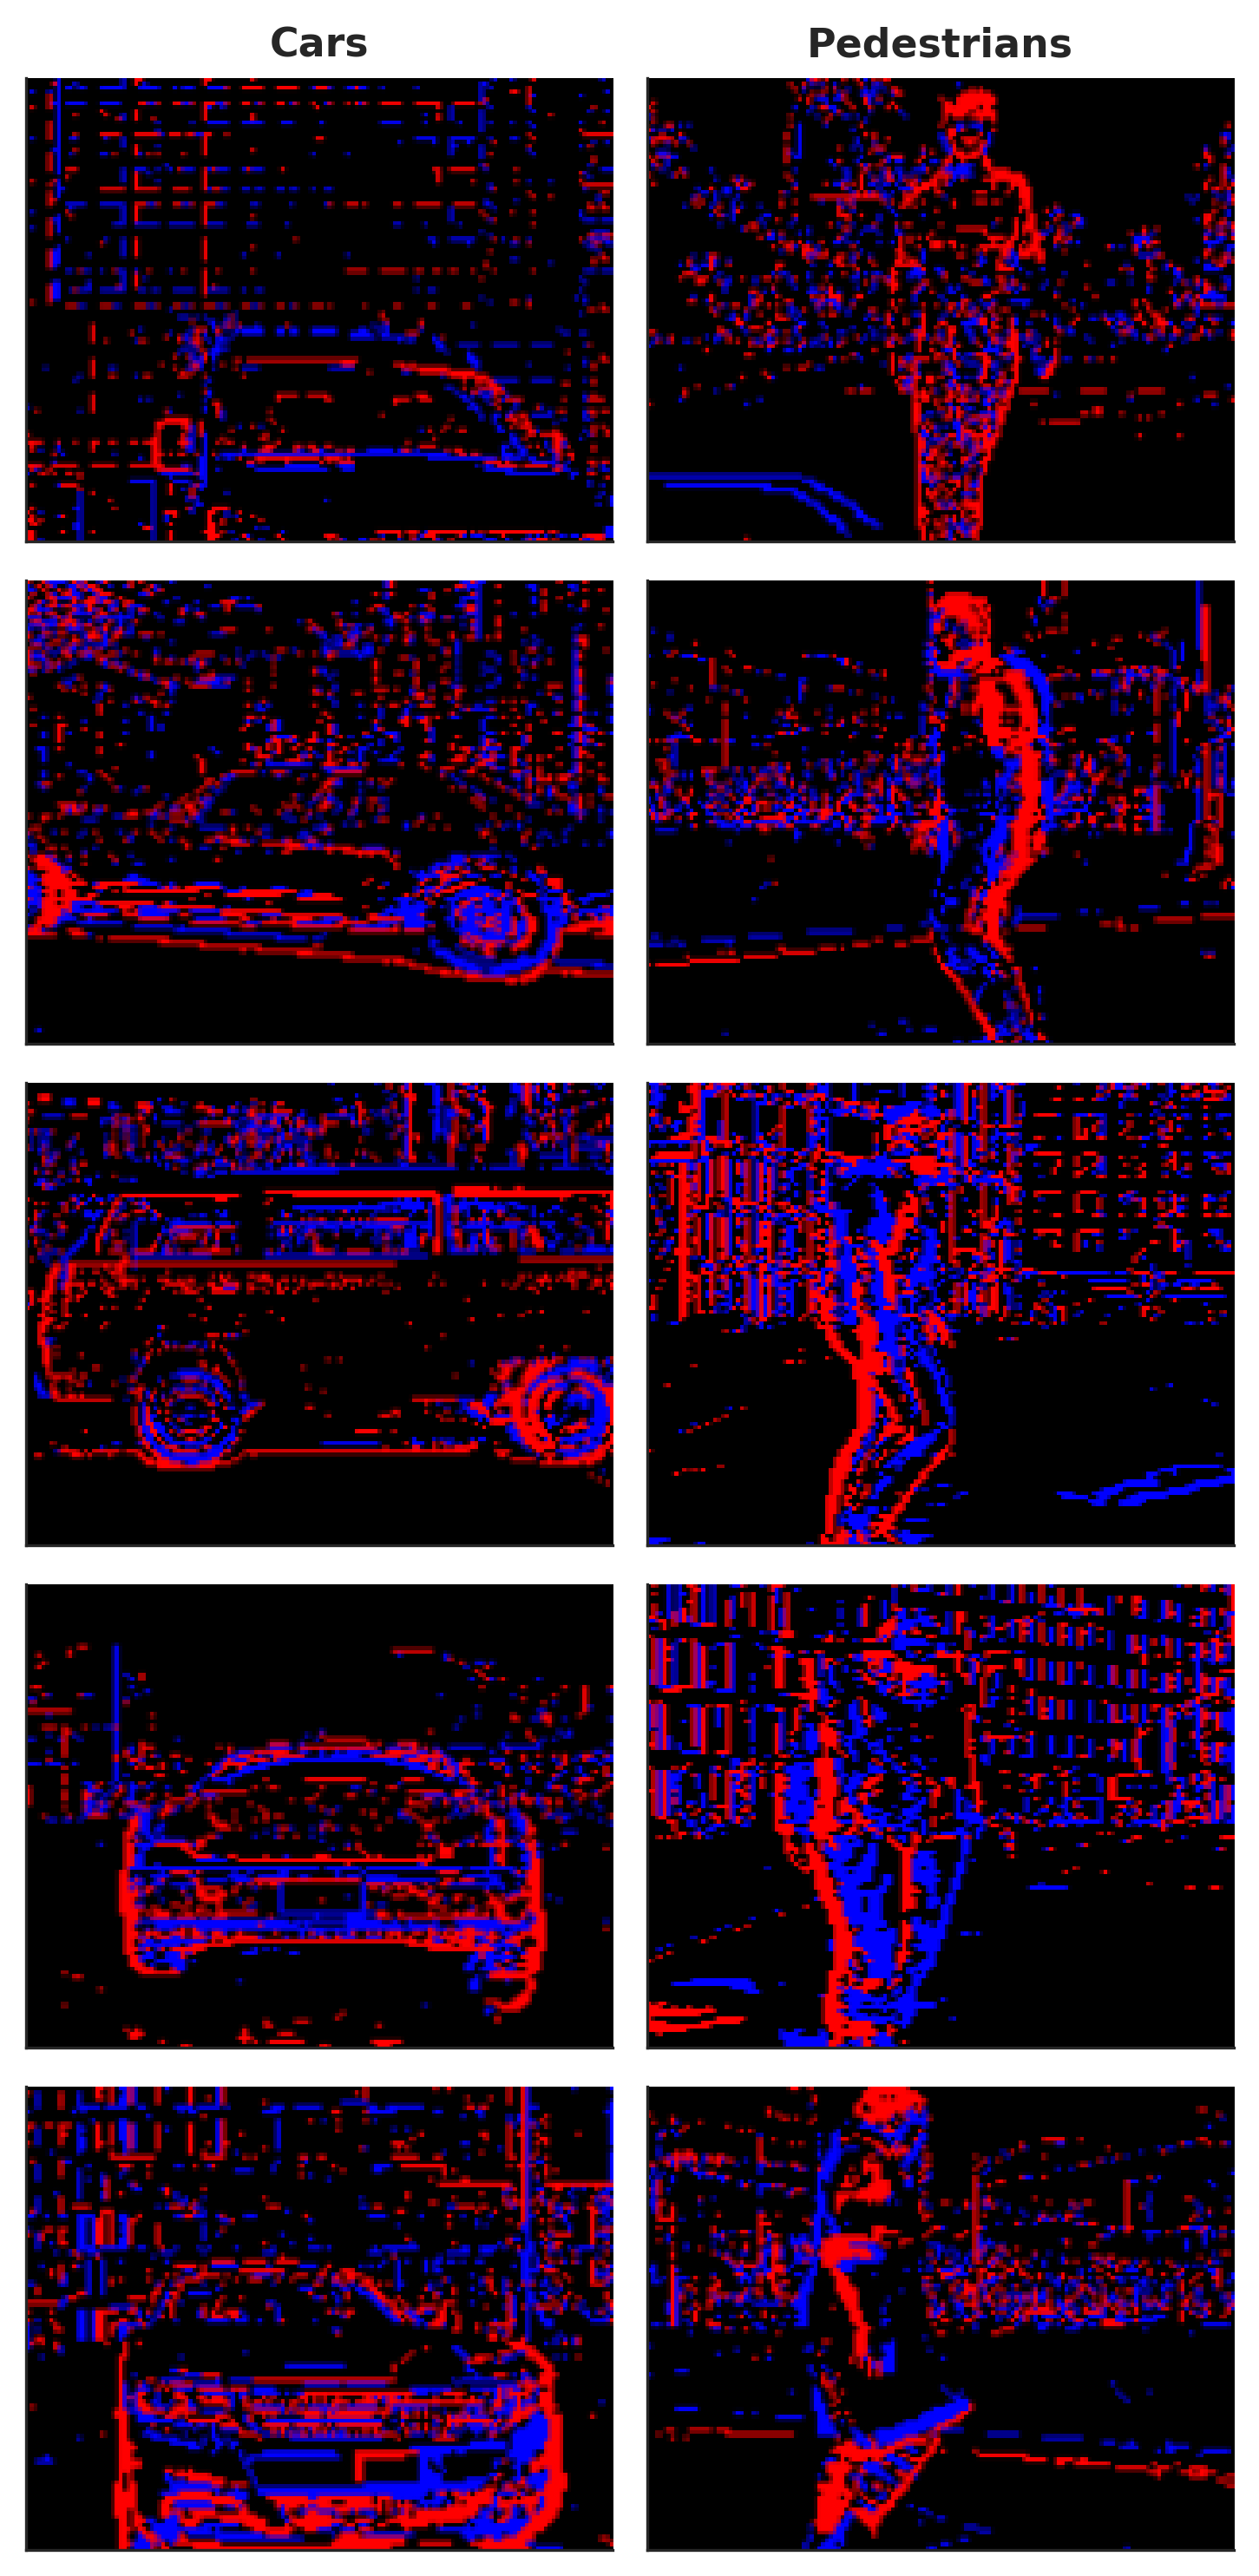

In [334]:
n_examples = 5

fig, ax = plt.subplots(n_examples, 2, figsize=(5, 2 * n_examples))

for i in range(n_examples):
    while True:
        idx = np.random.randint(n_data)
        sample, label = dataset[idx]
        if label == 0:
            break
    ax[i, 0].imshow(sample.permute(1, 2, 0))
    # remove ticks
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    if i == 0:
        ax[i, 0].set_title("Cars")

    while True:
        idx = np.random.randint(n_data)
        sample, label = dataset[idx]
        if label == 1:
            break
    ax[i, 1].imshow(sample.permute(1,2,0))

    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    if i == 0:
        ax[i, 1].set_title("Pedestrians")

fig.tight_layout()

fig.savefig("carla_samples.png", dpi=300)

plt.show()

In [294]:
N_RUNS = 10
N_EPOCHS = 30
LEARNING_RATE = 1e-5

BATCH_SIZE = 32


val_acc = np.empty((N_RUNS, N_EPOCHS))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, run in enumerate(range(N_RUNS)):
    train_data, test_data = torch.utils.data.random_split(dataset, [n_train, n_val])
    dataloader_train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    rsn = resnet18(pretrained=False)
    rsn.fc = Linear(512, N_OUT)
    rsn.conv1 = Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )

    rsn = rsn.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rsn.parameters(), lr=LEARNING_RATE)

    print(f"Run {run}")
    for j, epoch in enumerate(range(N_EPOCHS)):
        rsn.train()
        for k, (images, labels) in enumerate(dataloader_train):
            images = images.to(device).float()
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = rsn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # if k % 100 == 0:
            #    print(f'Epoch {epoch}, step {k}, loss: {loss.item()}')

        rsn.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in dataloader_test:
                images = images.to(device).float()
                labels = labels.to(device)

                outputs = rsn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc[i, j] = correct / total

            print(f"Epoch {epoch}, accuracy: {correct / total}")

/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run 0
Epoch 0, accuracy: 0.48214285714285715
Epoch 1, accuracy: 0.48214285714285715
Epoch 2, accuracy: 0.5446428571428571
Epoch 3, accuracy: 0.8392857142857143
Epoch 4, accuracy: 0.8839285714285714
Epoch 5, accuracy: 0.9285714285714286
Epoch 6, accuracy: 0.8839285714285714
Epoch 7, accuracy: 0.9107142857142857
Epoch 8, accuracy: 0.9642857142857143
Epoch 9, accuracy: 0.9464285714285714
Epoch 10, accuracy: 0.9196428571428571
Epoch 11, accuracy: 0.9464285714285714
Epoch 12, accuracy: 0.9375
Epoch 13, accuracy: 0.9642857142857143
Epoch 14, accuracy: 0.9732142857142857
Epoch 15, accuracy: 0.9553571428571429
Epoch 16, accuracy: 0.9553571428571429
Epoch 17, accuracy: 0.9732142857142857
Epoch 18, accuracy: 0.9642857142857143
Epoch 19, accuracy: 0.9553571428571429
Epoch 20, accuracy: 0.9196428571428571
Epoch 21, accuracy: 0.9642857142857143
Epoch 22, accuracy: 0.9375
Epoch 23, accuracy: 0.9732142857142857
Epoch 24, accuracy: 0.9821428571428571
Epoch 25, accuracy: 0.9553571428571429
Epoch 26, ac

In [311]:
print(f"Final accuracy: {val_acc.mean(axis=0)[-1]} +- {val_acc.std(axis=0)[-1]}")

Final accuracy: 0.9794642857142856 +- 0.008973103233143645


In [295]:
torch.save(rsn.state_dict(), "resnet18_atis.pt")

In [296]:
rsn.load_state_dict(torch.load("resnet18_atis.pt"))

<All keys matched successfully>

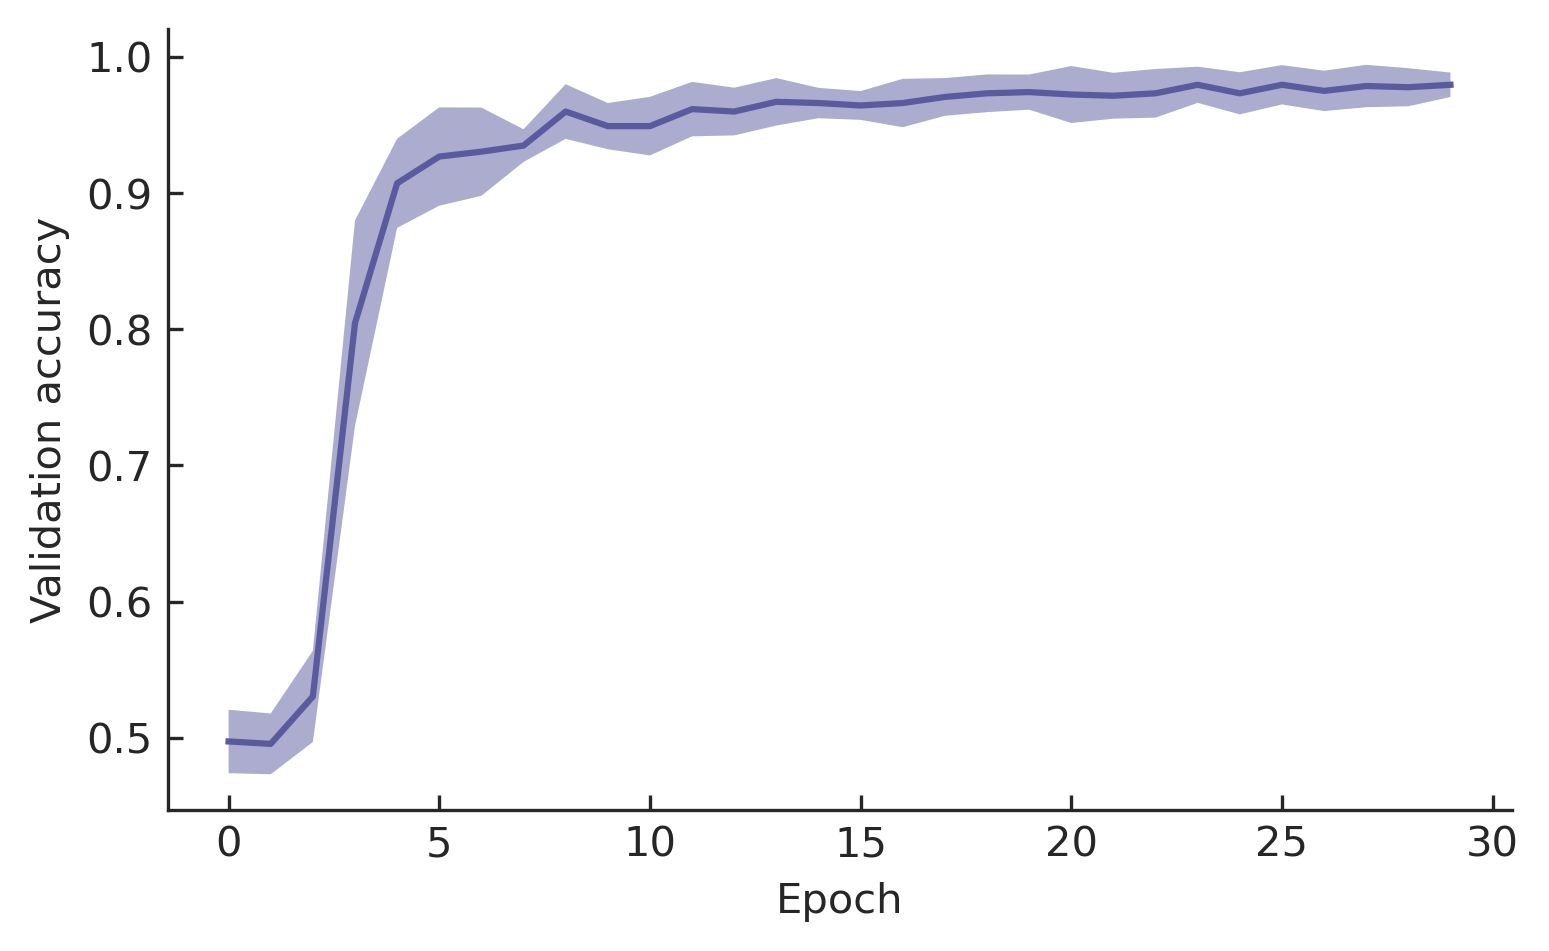

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(val_acc.mean(axis=0))
ax.fill_between(
    range(N_EPOCHS),
    val_acc.mean(axis=0) - val_acc.std(axis=0),
    val_acc.mean(axis=0) + val_acc.std(axis=0),
    alpha=0.5
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')

fig.tight_layout(pad=0.1)

#plt.ylim(bottom=0.)

fig.savefig("carla_samples_training.png", dpi=300)

plt.show()

In [23]:
labels_test[:40]

array([1., 1., 2., 1., 1., 2., 2., 2., 2., 0., 2., 1., 2., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 2., 2., 2., 0., 0., 2., 2., 0., 0., 2., 2.,
       2., 1., 0., 0., 0., 2.])

In [24]:
preds_test[:40]

array([1., 1., 2., 1., 1., 2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 2., 1.,
       1., 2., 2., 1., 2., 0., 2., 2., 2., 0., 2., 2., 0., 1., 1., 2., 2.,
       2., 1., 2., 0., 0., 2.])

In [13]:
label_map = ['Cars', 'Pedestrians', 'None']

labels_true_test = [label_map[int(i)] for i in labels_test]
labels_pred_test = [label_map[int(i)] for i in preds_test]

df_test = pd.DataFrame({'true': labels_true_test, 'predicted': labels_pred_test})

In [28]:
labels_true_binary = np.array([int(i != 2) for i in labels_test])
labels_pred_binary = np.array([int(i != 2) for i in preds_test])

In [29]:
labels_true_binary[:4]

array([1, 1, 0, 1])

In [30]:
labels_pred_binary[:4]

array([1, 1, 0, 1])

In [31]:
print("binary accuracy:", np.mean(labels_true_binary == labels_pred_binary))

#sns.heatmap(data=df_test[(df_test["true"]!="Pedestrians") & (df_test["predicted"] != "Pedestrians")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
#plt.show()

binary accuracy: 0.7187187187187187


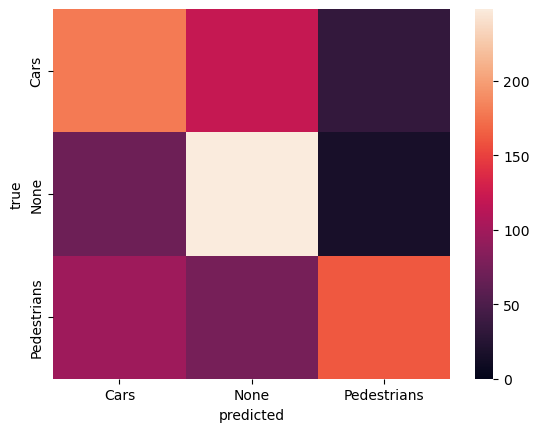

In [32]:
sns.heatmap(data=df_test.groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without pedestrians: 0.6920583468395461


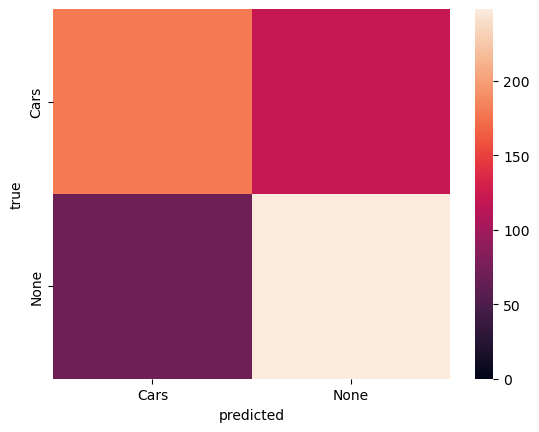

In [16]:
labels_test_without_pedestrians = labels_test[(labels_test != 1) & (preds_test != 1)]
preds_test_without_pedestrians = preds_test[(labels_test != 1) & (preds_test != 1)]

print("accuracy without pedestrians:", np.mean(labels_test_without_pedestrians == preds_test_without_pedestrians))

sns.heatmap(data=df_test[(df_test["true"]!="Pedestrians") & (df_test["predicted"] != "Pedestrians")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without none: 0.6994545796501787


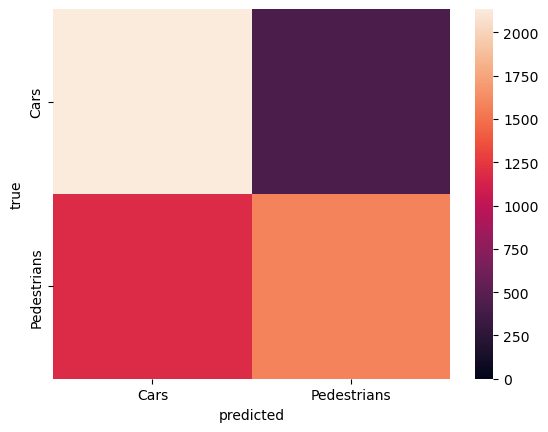

In [83]:
labels_test_without_none = labels_test[(labels_test != 2) & (preds_test != 2)]
preds_test_without_none = preds_test[(labels_test != 2) & (preds_test != 2)]

print("accuracy without none:", np.mean(labels_test_without_none == preds_test_without_none))

sns.heatmap(data=df_test[(df_test["true"]!="None") & (df_test["predicted"] != "None")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()